<a href="https://colab.research.google.com/github/mickeyfeliciano/IST-718/blob/main/Feliciano_Sec1_Lab3_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Package Import

In [ ]:
# import packages for analysis and modeling
import pandas as pd #data frame operations
from scipy.stats import uniform #for training and test splits
import statsmodels.api as smf #R-like model specification
import matplotlib.pyplot as plt #2D plotting
import numpy as np; np.random.seed(42)
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from IPython.display import HTML, display

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Acquisition and Cleaning

In [ ]:
#Read in modified data and create new dataframe
NewCoaches = pd.read_csv("https://raw.githubusercontent.com/mickeyfeliciano/IST-718/main/Lab%203/NCAA_Combined_Feliciano.csv")
NewCoaches.head()

,Year,School,Conference,Coach,SchoolPay,StadiumSize
0,2017,Alabama,SEC,Nick Saban,11132000.0,101821
1,2019,Clemson,ACC,Dabo Swinney,10250000.0,81500
2,2020,Alabama,SEC,Nick Saban,9100000.0,101821
3,2019,Alabama,SEC,Nick Saban,8700000.0,101821
4,2020,LSU,SEC,Ed Orgeron,8687500.0,102321


In [ ]:
NewCoaches.isnull().sum()
print(NewCoaches[NewCoaches.SchoolPay.isnull()])
NewCoaches = NewCoaches.dropna()
print(NewCoaches[NewCoaches.SchoolPay.isnull()])

     Year              School  ... SchoolPay StadiumSize
479  2020           Air Force  ...       NaN       46692
480  2019           Air Force  ...       NaN       46692
481  2017           Air Force  ...       NaN       46692
482  2020                Army  ...       NaN       38000
483  2019                Army  ...       NaN       38000
484  2017                Army  ...       NaN       38000
485  2020              Baylor  ...       NaN       45140
486  2018              Baylor  ...       NaN       45140
487  2017              Baylor  ...       NaN       45140
488  2020      Boston College  ...       NaN       44500
489  2020       Brigham Young  ...       NaN       63725
490  2019       Brigham Young  ...       NaN       63725
491  2018       Brigham Young  ...       NaN       63725
492  2017       Brigham Young  ...       NaN       63725
493  2020                Duke  ...       NaN       33941
494  2020             Liberty  ...       NaN       21088
495  2020        Miami (Fla.)  

In [ ]:
#Read in Win/Loss records
#from google.colab import files
#files.upload()
records = pd.read_csv("https://raw.githubusercontent.com/mickeyfeliciano/IST-718/main/Lab%203/sportsref_download.csv")
records = records.drop(columns=['W', 'L'])
records = records.rename(columns = {'Pct' : 'WinPercentage'})
records.head()
records.isnull().sum()

Year             0
School           0
WinPercentage    0
dtype: int64

In [ ]:
NewCoaches = pd.merge(NewCoaches, records,  how='left', left_on=['Year','School'], right_on = ['Year','School'])
NewCoaches.head()

,Year,School,Conference,Coach,SchoolPay,StadiumSize,WinPercentage
0,2017,Alabama,SEC,Nick Saban,11132000.0,101821,0.929
1,2019,Clemson,ACC,Dabo Swinney,10250000.0,81500,0.933
2,2020,Alabama,SEC,Nick Saban,9100000.0,101821,1.000
3,2019,Alabama,SEC,Nick Saban,8700000.0,101821,0.846
4,2020,LSU,SEC,Ed Orgeron,8687500.0,102321,0.500


In [ ]:
gradrates = pd.read_csv("https://raw.githubusercontent.com/mickeyfeliciano/IST-718/main/Lab%203/NCAA_GradRates.csv")
gradrates = gradrates.drop(columns=['Conference'])
gradrates.head()

,School,State,GSR,FSR
0,Akron,OH,78,67.0
1,Alabama,AL,88,63.0
2,Alabama at Birmingham,AL,73,47.0
3,Appalachian State,NC,77,65.0
4,Arizona,AZ,78,56.0


In [ ]:
NewCoaches = pd.merge(NewCoaches, gradrates,  how='left', left_on=['School'], right_on = ['School'])
NewCoaches = NewCoaches.drop(columns=['Coach', 'State'])
NewCoaches.head()

,Year,School,Conference,SchoolPay,StadiumSize,WinPercentage,GSR,FSR
0,2017,Alabama,SEC,11132000.0,101821,0.929,88,63.0
1,2019,Clemson,ACC,10250000.0,81500,0.933,83,59.0
2,2020,Alabama,SEC,9100000.0,101821,1.000,88,63.0
3,2019,Alabama,SEC,8700000.0,101821,0.846,88,63.0
4,2020,LSU,SEC,8687500.0,102321,0.500,66,32.0


## EDA and Vizuals

In [ ]:
#Correlation Heatmap
plt.figure(figsize=(15, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(NewCoaches.corr(), annot = True, cmap=cmap)

In [ ]:
#Looking at averages by conference
NewCoaches.groupby('Conference').mean().round(0)

,Year,SchoolPay,StadiumSize,WinPercentage,GSR,FSR
Conference,,,,,,
AAC,2018.0,1800834.0,45670.0,1.0,81.0,67.0
ACC,2018.0,3615490.0,59415.0,1.0,83.0,68.0
Big 12,2018.0,3811799.0,63741.0,1.0,77.0,59.0
Big Ten,2018.0,4245664.0,72311.0,1.0,86.0,68.0
C-USA,2018.0,844224.0,37427.0,0.0,76.0,58.0
Ind.,2019.0,1004777.0,51493.0,0.0,77.0,63.0
MAC,2018.0,578918.0,25671.0,0.0,81.0,65.0
Mt. West,2018.0,1033531.0,38741.0,0.0,77.0,59.0
Pac-12,2018.0,3129006.0,58056.0,1.0,82.0,64.0


In [ ]:
NewCoaches.SchoolPay.describe().round(0)

count         479.0
mean      2458882.0
std       1964780.0
min        350000.0
25%        800000.0
50%       1900008.0
75%       3612388.0
max      11132000.0
Name: SchoolPay, dtype: float64

In [ ]:
#Looking at top GSR
NewCoaches.sort_values(['GSR'],ascending=False).groupby('School').head()

,Year,School,Conference,SchoolPay,StadiumSize,WinPercentage,GSR,FSR
198,2019,Duke,ACC,2540928.0,33941,0.417,97,92.0
147,2017,Northwestern,Big Ten,3305818.0,47130,0.769,97,93.0
199,2018,Duke,ACC,2540928.0,33941,0.615,97,92.0
191,2017,Duke,ACC,2613638.0,33941,0.538,97,92.0
118,2019,Northwestern,Big Ten,3619775.0,47130,0.250,97,93.0
...,...,...,...,...,...,...,...,...
341,2019,New Mexico,Mt. West,823740.0,39224,0.167,61,34.0
31,2017,Florida State,ACC,5700000.0,82300,0.538,51,35.0
39,2019,Florida State,ACC,5000000.0,82300,0.462,51,35.0
93,2020,Florida State,ACC,4000000.0,82300,0.333,51,35.0


In [ ]:
#GSR quantiles
NewCoaches.GSR.quantile(np.linspace(.1, 1, 9, 0))

0.1    69.0
0.2    72.0
0.3    75.0
0.4    77.0
0.5    80.0
0.6    83.0
0.7    86.0
0.8    88.0
0.9    90.0
Name: GSR, dtype: float64

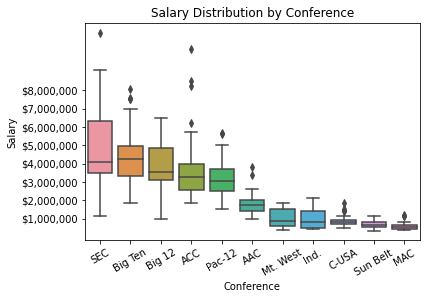

In [ ]:
#Hierarchical distribution of Salary by Conference
sns.boxplot(y=NewCoaches.SchoolPay, x=NewCoaches.Conference, order = ["SEC", "Big Ten", "Big 12", "ACC","Pac-12","AAC","Mt. West","Ind.", "C-USA","Sun Belt", "MAC"])
plt.xlabel('Conference')
plt.ylabel('Salary')
plt.title('Salary Distribution by Conference')
plt.xticks(rotation=30)
plt.yticks([1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 7000000, 8000000], ["$1,000,000", "$2,000,000", "$3,000,000", "$4,000,000", "$5,000,000", "$6,000,000", "$7,000,000", "$8,000,000"])
plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.3, 0.95, '$\\mu=2458882.08$\n$\\mathrm{median}=1900008.00$')

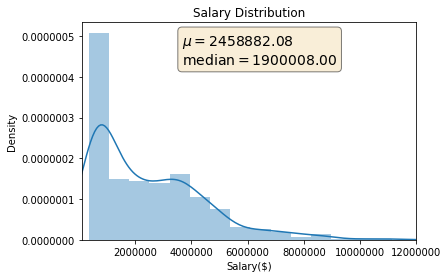

In [ ]:
#Salary distribution histogram
fig, ax = plt.subplots()
x = NewCoaches.SchoolPay
sns.distplot(x, bins=15) 
plt.xlabel('Salary($)')
plt.title('Salary Distribution')
ax.set_xlim(100000,12000000)
ax.ticklabel_format(useOffset=False, style='plain')
mu = x.mean()
median = np.median(x)
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.3, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

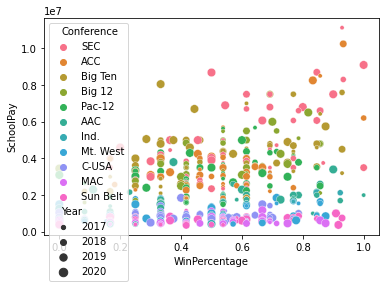

In [ ]:
#Unuseful plot
sns.scatterplot(x="WinPercentage", y="SchoolPay", hue = "Conference", size = "Year", data=NewCoaches)

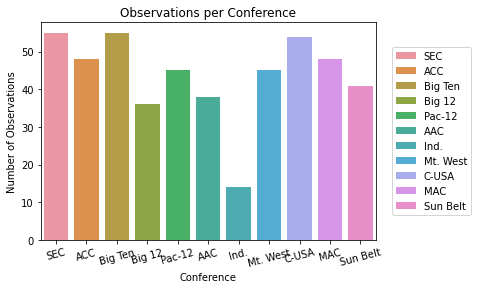

In [ ]:
# Number of Observations per conference
sns.countplot(x='Conference', data=NewCoaches, hue='Conference', dodge=False)
_ = plt.xlabel('Conference')
_ = plt.ylabel('Number of Observations')
_ = plt.title('Observations per Conference')
_ = plt.legend(loc='center right', bbox_to_anchor=[1.3, 0.5])
_ = plt.xticks(rotation=15)
plt.show()

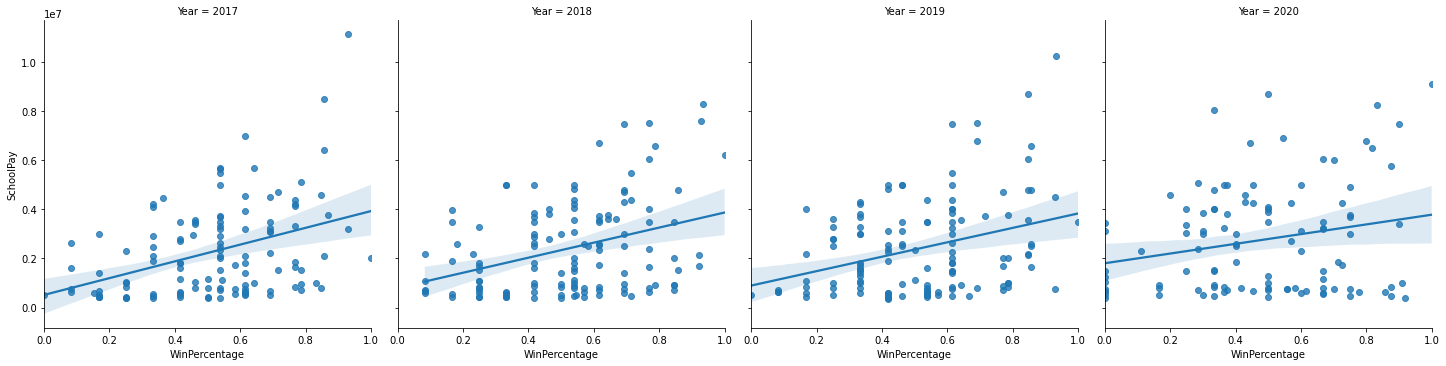

In [ ]:
#Looking at Win Percentage and School Pay per year
sns.lmplot(x="WinPercentage", y="SchoolPay", col = "Year", data=NewCoaches)

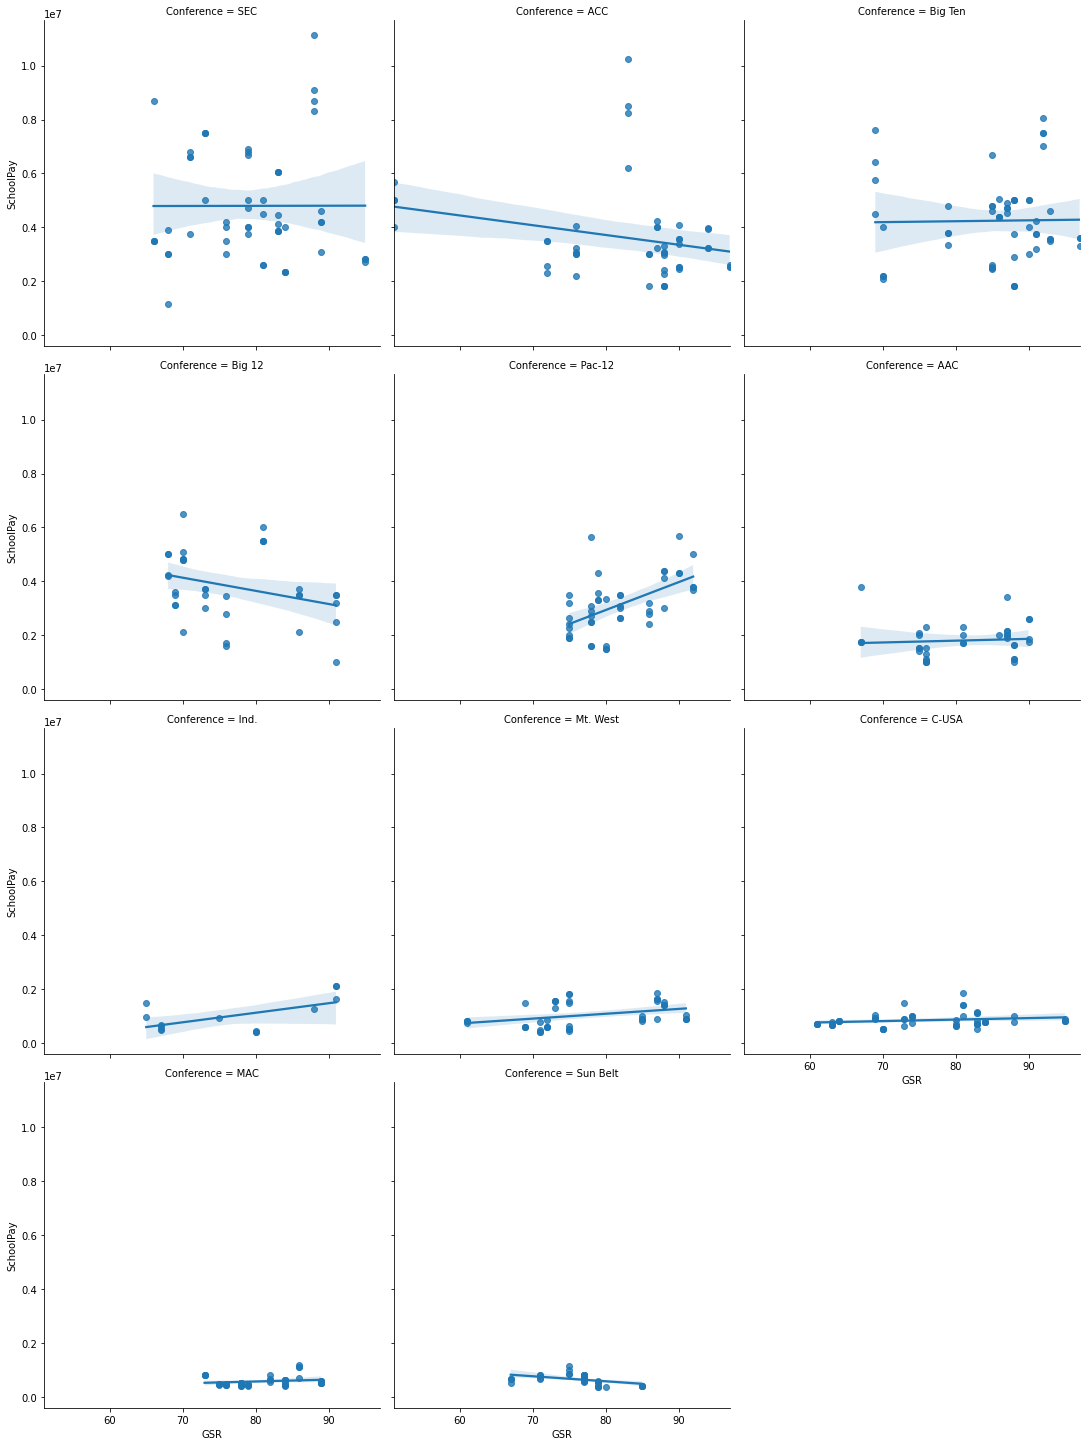

In [ ]:
#GSR/School Pay by Conference
sns.lmplot(x="GSR", y="SchoolPay", col="Conference", col_wrap=3, data=NewCoaches);

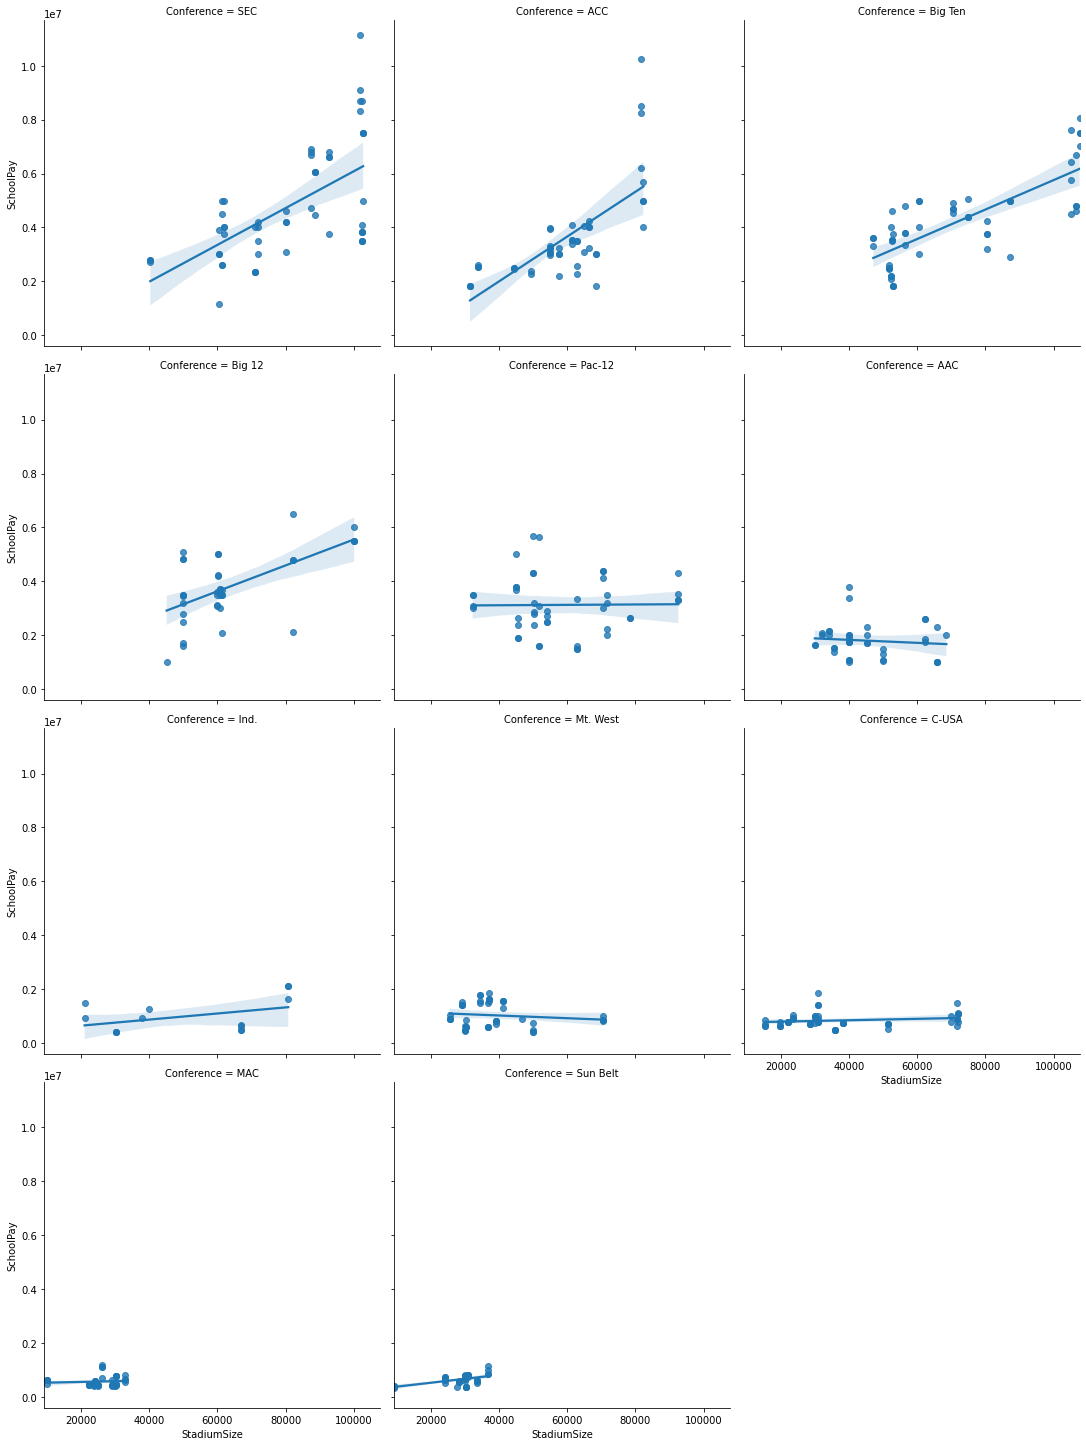

In [ ]:
#GSR/School Pay by Conference
sns.lmplot(x="StadiumSize", y="SchoolPay", col="Conference", col_wrap=3, data=NewCoaches);

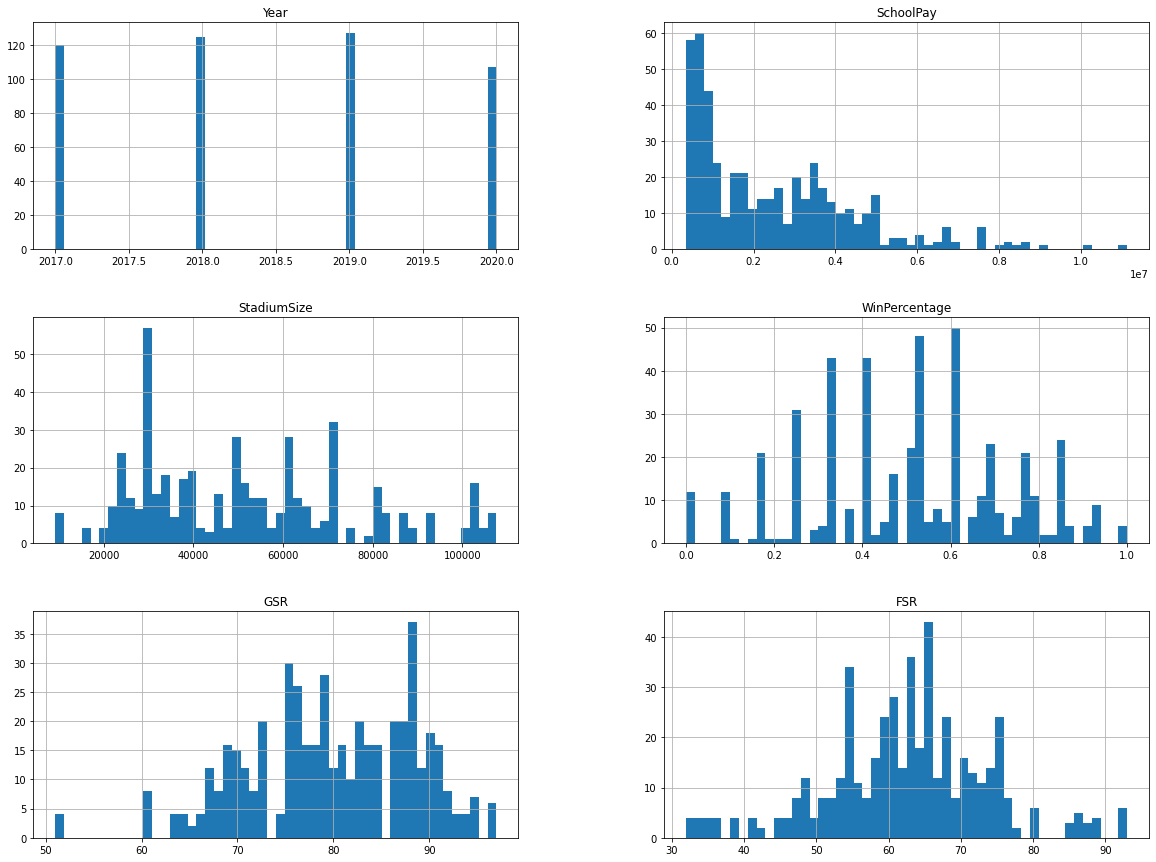

In [ ]:
%matplotlib inline
NewCoaches.hist(bins = 50, figsize=(20,15))
plt.show()

## Models

In [ ]:
#Instantiating dataset for models
currentdata = NewCoaches[(NewCoaches['Year']!=2017)]
currentdata = NewCoaches[(NewCoaches['Year']!=2018)]
target = currentdata[currentdata['School']=='Syracuse']
currentdata = currentdata[(currentdata['School']!='Syracuse')]
print(currentdata)

     Year            School Conference  ...  WinPercentage  GSR   FSR
0    2017           Alabama        SEC  ...          0.929   88  63.0
1    2019           Clemson        ACC  ...          0.933   83  59.0
2    2020           Alabama        SEC  ...          1.000   88  63.0
3    2019           Alabama        SEC  ...          0.846   88  63.0
4    2020               LSU        SEC  ...          0.500   66  32.0
..    ...               ...        ...  ...            ...  ...   ...
474  2017  Louisiana-Monroe   Sun Belt  ...          0.333   85  68.0
475  2020  Louisiana-Monroe   Sun Belt  ...          0.000   85  68.0
476  2017  New Mexico State   Sun Belt  ...          0.538   80  59.0
477  2020  Coastal Carolina   Sun Belt  ...          0.917   79  61.0
478  2019  Coastal Carolina   Sun Belt  ...          0.417   79  61.0

[353 rows x 8 columns]


In [ ]:
#Preparing data for linear regression
#Converting categorical variables to numeric for regression model
#Reference: https://vitalflux.com/labelencoder-example-single-multiple-columns/
cols = ['School', 'Conference']
currentdata[cols] = currentdata[cols].apply(LabelEncoder().fit_transform)
#Defining variables
x = currentdata[['School', 'Conference', 'StadiumSize','WinPercentage','GSR']]
y = currentdata['SchoolPay']
currentdata.head()

,Year,School,Conference,SchoolPay,StadiumSize,WinPercentage,GSR,FSR
0,2017,1,9,11132000.0,101821,0.929,88,63.0
1,2019,20,1,10250000.0,81500,0.933,83,59.0
2,2020,1,9,9100000.0,101821,1.000,88,63.0
3,2019,1,9,8700000.0,101821,0.846,88,63.0
4,2020,47,9,8687500.0,102321,0.500,66,32.0


In [ ]:
#Fitting linear regression from sklearn
reg=LinearRegression()
reg.fit(x,y)
Intercept=reg.intercept_
Coefficients=reg.coef_
print(Intercept)
print(Coefficients)

-2414172.693344855
[-2.52157182e+03 -1.91067201e+04  6.16585078e+01  8.57547681e+05
  1.89568084e+04]


In [ ]:
#Sklearn Linear Regression model
#Reference: https://towardsdatascience.com/machine-learning-simple-linear-regression-with-python-f04ecfdadc13
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=1/3, random_state=9)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
#print(y_pred.round())
accuracy = (regressor.score(X_test,y_test))
print(accuracy)

0.5925057396316726


In [ ]:
#Creating ordinary least squares model and fitting
#Reference: https://heartbeat.fritz.ai/implementing-ordinary-least-squares-ols-using-statsmodels-in-python-b1f4dee09419
model1 = smf.OLS(y,x).fit()
#Printing results
print(model1.summary())

                                 OLS Regression Results                                
Dep. Variable:              SchoolPay   R-squared (uncentered):                   0.842
Model:                            OLS   Adj. R-squared (uncentered):              0.840
Method:                 Least Squares   F-statistic:                              370.4
Date:                Tue, 27 Apr 2021   Prob (F-statistic):                   6.01e-137
Time:                        18:23:31   Log-Likelihood:                         -5460.7
No. Observations:                 353   AIC:                                  1.093e+04
Df Residuals:                     348   BIC:                                  1.095e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [ ]:
#Preparing second model with only statistically significant coefficients
x2 = currentdata[['Conference', 'StadiumSize','WinPercentage','GSR']]
y2 = currentdata['SchoolPay']

currentdata.head()
# Building training and test sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=1/3, random_state=9)

In [ ]:
#Dropping 'School' Coefficient and creating second model
model2 = smf.OLS(y2,x2).fit()
#Printing results
print(model2.summary())

                                 OLS Regression Results                                
Dep. Variable:              SchoolPay   R-squared (uncentered):                   0.840
Model:                            OLS   Adj. R-squared (uncentered):              0.838
Method:                 Least Squares   F-statistic:                              459.0
Date:                Tue, 27 Apr 2021   Prob (F-statistic):                   1.42e-137
Time:                        18:23:31   Log-Likelihood:                         -5462.4
No. Observations:                 353   AIC:                                  1.093e+04
Df Residuals:                     349   BIC:                                  1.095e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [ ]:
#Preparing third model with only statistically significant coefficients
x3 = currentdata[['StadiumSize', 'WinPercentage','GSR']]
y3 = currentdata['SchoolPay']

currentdata.head()
# Building training and test sets
X_train3, X_test3, y_train3, y_test3 = train_test_split(x3, y3, test_size=1/3, random_state=9)

In [ ]:
#Creating third modeling and displaying results
model3 = smf.OLS(y3, x3)
results3 = model3.fit()
print(results3.summary())

                                 OLS Regression Results                                
Dep. Variable:              SchoolPay   R-squared (uncentered):                   0.839
Model:                            OLS   Adj. R-squared (uncentered):              0.837
Method:                 Least Squares   F-statistic:                              606.0
Date:                Tue, 27 Apr 2021   Prob (F-statistic):                   3.43e-138
Time:                        18:23:31   Log-Likelihood:                         -5464.3
No. Observations:                 353   AIC:                                  1.093e+04
Df Residuals:                     350   BIC:                                  1.095e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [ ]:
#Predictions
#Make conference = 1 and school = 126
target = target.replace(['Syracuse'], 126)
target = target.replace(['ACC'], 1)
target = target[['Conference', 'StadiumSize', 'WinPercentage', 'GSR']]
#print(target)
ypred = model2.predict(target)
print(ypred.round(0))

218    2360415.0
dtype: float64


In [ ]:
#Aggregating Salaries by Conference
result = NewCoaches.groupby('Conference').agg({'SchoolPay': ['min', 'mean', 'max']}).round(0)
print("Mean, min, and max values of SchoolPay grouped by Conference")
print(result)

Mean, min, and max values of SchoolPay grouped by Conference
            SchoolPay                       
                  min       mean         max
Conference                                  
AAC         1000000.0  1800834.0   3800000.0
ACC         1827370.0  3615490.0  10250000.0
Big 12      1000000.0  3811799.0   6507143.0
Big Ten     1830000.0  4245664.0   8054000.0
C-USA        500000.0   844224.0   1850000.0
Ind.         419640.0  1004777.0   2129638.0
MAC          405500.0   578918.0   1175000.0
Mt. West     400008.0  1033531.0   1850000.0
Pac-12      1500000.0  3129006.0   5680441.0
SEC         1160000.0  4797760.0  11132000.0
Sun Belt     350000.0   645342.0   1150000.0


In [ ]:
#Same info, prettier table
import plotly.graph_objects as go
title = ['Conference','Loweset Salary', 'Average Salary', 'Highest Salary']
conferences = ['AAC', 'ACC', 'Big 12', 'Big Ten', 'C-USA', 'Ind.', 'MAC', 'Mt. West', 'Pac-12', 'SEC', 'Sun Belt']
minsal = [1000000, 1827370, 1000000, 1830000, 500000, 419640, 405500, 400008, 1500000, 1160000, 350000]
meansal = [1800834,3615490, 3811799, 4245664, 844224, 1004777, 578918, 1033531, 3129006, 4797760, 645342]
maxsal = [3800000,10250000,6507143,8054000,1850000, 2129638,1175000,1850000,5680441, 11132000, 1150000]

fig = go.Figure(data=[go.Table(header=dict(values=title, font=dict(color='black', size=12)),
                 cells=dict(values=[conferences, minsal, meansal, maxsal], font=dict(color='black', size=12)))
                     ])
fig.update_layout(width=600, height=800)
fig.show()

### Other Predictions

In [ ]:
#Instantiating dataset for ACC prediction
predictdata = NewCoaches[(NewCoaches['Year']!=2017)]
predictdata = NewCoaches[(NewCoaches['Year']!=2018)]
secondtarget = predictdata[predictdata['School']=='Clemson']
predictdata = predictdata[(predictdata['School']!='Clemson')]
print(predictdata)

     Year            School Conference  ...  WinPercentage  GSR   FSR
0    2017           Alabama        SEC  ...          0.929   88  63.0
2    2020           Alabama        SEC  ...          1.000   88  63.0
3    2019           Alabama        SEC  ...          0.846   88  63.0
4    2020               LSU        SEC  ...          0.500   66  32.0
8    2020          Michigan    Big Ten  ...          0.333   92  73.0
..    ...               ...        ...  ...            ...  ...   ...
474  2017  Louisiana-Monroe   Sun Belt  ...          0.333   85  68.0
475  2020  Louisiana-Monroe   Sun Belt  ...          0.000   85  68.0
476  2017  New Mexico State   Sun Belt  ...          0.538   80  59.0
477  2020  Coastal Carolina   Sun Belt  ...          0.917   79  61.0
478  2019  Coastal Carolina   Sun Belt  ...          0.417   79  61.0

[351 rows x 8 columns]


In [ ]:
#Converting categorical variables to numeric for regression model
cols = ['School', 'Conference']
predictdata[cols] = predictdata[cols].apply(LabelEncoder().fit_transform)
#Defining variables
x = predictdata[['School', 'Conference', 'StadiumSize','WinPercentage','GSR']]
y = predictdata['SchoolPay']
predictdata.head()

,Year,School,Conference,SchoolPay,StadiumSize,WinPercentage,GSR,FSR
0,2017,1,9,11132000.0,101821,0.929,88,63.0
2,2020,1,9,9100000.0,101821,1.000,88,63.0
3,2019,1,9,8700000.0,101821,0.846,88,63.0
4,2020,46,9,8687500.0,102321,0.500,66,32.0
8,2020,58,3,8054000.0,107601,0.333,92,73.0


In [ ]:
#Preparing model2 from previous section for new predictions
x4 = predictdata[['Conference', 'StadiumSize','WinPercentage','GSR']]
y4 = predictdata['SchoolPay']

predictdata.head()
# Building training and test sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(x4, y4, test_size=1/3, random_state=9)

In [ ]:
#Running second model for ACC target
model4 = smf.OLS(y4,x4).fit()
#Printing results
print(model4.summary())

                                 OLS Regression Results                                
Dep. Variable:              SchoolPay   R-squared (uncentered):                   0.847
Model:                            OLS   Adj. R-squared (uncentered):              0.845
Method:                 Least Squares   F-statistic:                              480.2
Date:                Tue, 27 Apr 2021   Prob (F-statistic):                   5.19e-140
Time:                        18:23:34   Log-Likelihood:                         -5412.7
No. Observations:                 351   AIC:                                  1.083e+04
Df Residuals:                     347   BIC:                                  1.085e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [ ]:
#Removing conference from model
x4 = predictdata[['StadiumSize','WinPercentage','GSR']]
y4 = predictdata['SchoolPay']

predictdata.head()
# Building training and test sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(x4, y4, test_size=1/3, random_state=9)

In [ ]:
#Running model for ACC target
model4 = smf.OLS(y4,x4).fit()
#Printing results
print(model4.summary())

                                 OLS Regression Results                                
Dep. Variable:              SchoolPay   R-squared (uncentered):                   0.846
Model:                            OLS   Adj. R-squared (uncentered):              0.845
Method:                 Least Squares   F-statistic:                              638.6
Date:                Tue, 27 Apr 2021   Prob (F-statistic):                   4.25e-141
Time:                        18:23:34   Log-Likelihood:                         -5413.5
No. Observations:                 351   AIC:                                  1.083e+04
Df Residuals:                     348   BIC:                                  1.084e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [ ]:
#Predictions
#Make conference = 0 and school = 126
secondtarget = secondtarget.replace(['Cincinnati'], 126)
secondtarget = secondtarget.replace(['AAC'], 0)
secondtarget = secondtarget[['StadiumSize', 'WinPercentage', 'GSR']]
#print(secondtarget)
ypred = model4.predict(secondtarget)
print(ypred.round(0))

1    4398443.0
5    4356819.0
7    4343675.0
dtype: float64


In [ ]:
#Instantiating dataset for Big Ten prediction
predictagain = NewCoaches[(NewCoaches['Year']!=2017)]
predictagain = NewCoaches[(NewCoaches['Year']!=2018)]
thirdtarget = predictagain[predictagain['School']=='Michigan']
predictagain = predictagain[(predictagain['School']!='Michigan')]
print(predictagain)
#Converting categorical variables to numeric for regression model
cols = ['School', 'Conference']
predictagain[cols] = predictagain[cols].apply(LabelEncoder().fit_transform)
#Defining variables
x = predictagain[['School', 'Conference', 'StadiumSize','WinPercentage','GSR']]
y = predictagain['SchoolPay']
predictagain.head()

     Year            School Conference  ...  WinPercentage  GSR   FSR
0    2017           Alabama        SEC  ...          0.929   88  63.0
1    2019           Clemson        ACC  ...          0.933   83  59.0
2    2020           Alabama        SEC  ...          1.000   88  63.0
3    2019           Alabama        SEC  ...          0.846   88  63.0
4    2020               LSU        SEC  ...          0.500   66  32.0
..    ...               ...        ...  ...            ...  ...   ...
474  2017  Louisiana-Monroe   Sun Belt  ...          0.333   85  68.0
475  2020  Louisiana-Monroe   Sun Belt  ...          0.000   85  68.0
476  2017  New Mexico State   Sun Belt  ...          0.538   80  59.0
477  2020  Coastal Carolina   Sun Belt  ...          0.917   79  61.0
478  2019  Coastal Carolina   Sun Belt  ...          0.417   79  61.0

[351 rows x 8 columns]


,Year,School,Conference,SchoolPay,StadiumSize,WinPercentage,GSR,FSR
0,2017,1,9,11132000.0,101821,0.929,88,63.0
1,2019,20,1,10250000.0,81500,0.933,83,59.0
2,2020,1,9,9100000.0,101821,1.000,88,63.0
3,2019,1,9,8700000.0,101821,0.846,88,63.0
4,2020,47,9,8687500.0,102321,0.500,66,32.0


In [ ]:
#Preparing previous model for Big 10 prediction
x5 = predictdata[['StadiumSize','WinPercentage','GSR']]
y5 = predictdata['SchoolPay']

predictdata.head()
# Building training and test sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(x5, y5, test_size=1/3, random_state=9)

In [ ]:
#Running model for Big 10 target
model5 = smf.OLS(y5,x5).fit()
#Printing results
print(model5.summary())

                                 OLS Regression Results                                
Dep. Variable:              SchoolPay   R-squared (uncentered):                   0.846
Model:                            OLS   Adj. R-squared (uncentered):              0.845
Method:                 Least Squares   F-statistic:                              638.6
Date:                Tue, 27 Apr 2021   Prob (F-statistic):                   4.25e-141
Time:                        18:23:34   Log-Likelihood:                         -5413.5
No. Observations:                 351   AIC:                                  1.083e+04
Df Residuals:                     348   BIC:                                  1.084e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [ ]:
#Prediction
#Make conference = 3 and school = 126
thirdtarget = thirdtarget.replace(['Michigan'], 126)
thirdtarget = thirdtarget.replace(['Big Ten'], 3)
thirdtarget = thirdtarget[['StadiumSize', 'WinPercentage', 'GSR']]
#print(secondtarget)
ypred = model5.predict(thirdtarget)
print(ypred.round(0))

8     5501610.0
10    5698229.0
15    5656057.0
dtype: float64
